# Mission to Mars


## Importing Libraries

In [36]:
# REQUIRED LIBRARIES
# DO NOT TOUCH THE CODE IN THIS CELL
import pandas as pd
import numpy as np
import warnings
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Validation
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, LabelEncoder
from sklearn.naive_bayes import GaussianNB


# Tuning
from sklearn.model_selection import GridSearchCV


# Feature Extraction
from sklearn.feature_selection import RFE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

warnings.filterwarnings('ignore')

In [31]:
# HELPER FUNCTIONS
# DO NOT TOUCH THE CODE IN THIS CELL
# Analyze Data
def explore_data(df):
    # print("Number of Crop Examples and Attributes:", df.shape)
    print ("Our dataset contains:", "{:,}".format(df.shape[0]), "examples of recorded crops")
    print('\n')
    print('Dataset columns:',df.columns)
    print('\n')
    print('Data types of each columns: ', df.info())

def draw_barplot(data, variable, orient='v'):
    if orient=='v':
        a=sns.countplot(data[variable])
    else:
        a=sns.countplot(y=data[variable], data=data, orient=orient)
    a.set_xlabel(variable,fontsize=20)
    a.set_ylabel("Number of cases",fontsize=20)
    a.tick_params(labelsize=15)

def calculate_average(field, label, df):
    average_temperature_per_label = df.groupby(label)[field].mean()
    print(average_temperature_per_label)
    

# Split training and validation set
def read_in_and_split_data(data, target):
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test
    
# Spot-Check Algorithms
def GetModel():
    Models = []
    Models.append(('SVM'  , SVC(probability=True)))
    return Models

# Train model
def fit_model(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=0)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    return names, results

# Save trained model
def save_model(model,filename):
    pickle.dump(model, open(filename, 'wb'))
    

# [Data Collection](http://)
In this workshop, we will skip the data collection step from the data science process, and use a readily available dataset: The Crop Recommendation Dataset.

This dataset would allow its users to build a smart model to recommend the most suitable crops to grow in a particular farm based on various parameters.

The dataset consist of 8 columns labelled as:

- **N** - ratio of Nitrogen content in soil
- **P** - ratio of Phosphorous content in soil
- **K** - ratio of Potassium content in soil
- **temperature** - temperature in degree Celsius
- **humidity** - relative humidity in %
- **ph** - ph value of the soil
- **rainfall** - rainfall in mm
- **Label** - the crop type planted


### Run the cell below to load and read the dataset

In [8]:
data = pd.read_csv('https://raw.githubusercontent.com/ladyhodhod/mission_to_mars_crop_recommendation_system/main/data/Crop_recommendation.csv')

### In order to display the content of this dataset, we can use the code in the cell below. When you run it, you will see random sample of recorded cases.

In [9]:
data.sample(5)

,N,P,K,temperature,humidity,ph,rainfall,label
785,27,60,17,26.417683,63.646983,7.026795,64.421771,blackgram
317,27,80,15,19.070962,21.210923,5.788387,86.219176,kidneybeans
840,5,65,19,18.280722,68.103654,6.978362,48.802533,lentil
119,74,55,19,18.050337,62.893670,6.288868,84.236135,maize
2169,111,28,26,27.773633,64.478587,6.937353,192.712124,coffee


### **STOP!**
### Take a few minutes to read the content of the table above. Getting to know the data, is a crucial step in data science.

# [Data Exploration](http://)

Let's first rename the columns to have easier variable names.

Run the cell below and check what happens.

In [12]:
data.columns=['Nitrogen','Phosphorus','Potassium','Temperature','Humidity','pH','Rainfall','Crop']
data.head(5)

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH,Rainfall,Crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [16]:
explore_data(data)

Our dataset contains: 2,200 examples of recorded crops


Dataset columns: Index(['Nitrogen', 'Phosphorus', 'Potassium', 'Temperature', 'Humidity', 'pH',
       'Rainfall', 'Crop'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     2200 non-null   int64  
 1   Phosphorus   2200 non-null   int64  
 2   Potassium    2200 non-null   int64  
 3   Temperature  2200 non-null   float64
 4   Humidity     2200 non-null   float64
 5   pH           2200 non-null   float64
 6   Rainfall     2200 non-null   float64
 7   Crop         2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
Data types of each columns:  None


Let's now check how many examples of each crop type exist in our dataset.

Run the cell below and explore the crops we are studying

In [17]:
data["Crop"].value_counts()

rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: Crop, dtype: int64

### What do you observe?

## Double click on this cell to write your observations.

### Let's visualize these using a plot!

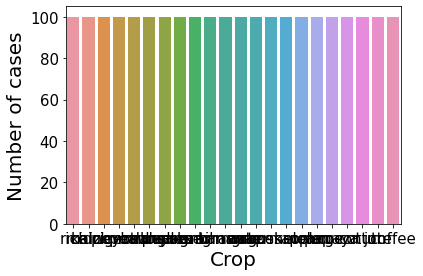

In [21]:
draw_barplot(data, 'Crop')

### Let's now calculate the average temperature needed for each crop type

In [26]:
# calculate_average('Temperature')
calculate_average('Temperature', 'Crop', data)

Crop
apple          22.630942
banana         27.376798
blackgram      29.973340
chickpea       18.872847
coconut        27.409892
coffee         25.540477
cotton         23.988958
grapes         23.849575
jute           24.958376
kidneybeans    20.115085
lentil         24.509052
maize          22.389204
mango          31.208770
mothbeans      28.194920
mungbean       28.525775
muskmelon      28.663066
orange         22.765725
papaya         33.723859
pigeonpeas     27.741762
pomegranate    21.837842
rice           23.689332
watermelon     25.591767
Name: Temperature, dtype: float64


### What is the crop requiring the highest temperature?

### Now it is your turn! 
### Calculate the average Humidity level required for each crop type.
Hint: Think of using the `calculate_average()` function provided to you!

In [28]:
# write your code here

# [Train an AI system](http://)

Now it is time to train an AI recommendation system that will learn how to recommend crops based on the different characteristics provided.

We use Machine Learning algorithms to build such a system!

### Start by running the cell below

In [37]:
target ='Crop'
X_train, X_test, y_train, y_test = read_in_and_split_data(data, target)

models = GetModel()
names,results = fit_model(X_train, y_train,models)
pipeline = make_pipeline(MinMaxScaler(), GaussianNB())
model = pipeline.fit(X_train, y_train)

SVM: 0.976705 (0.008214)


# [Predict unseen data](http://)

Let's now use our system to decide which crop type we should grow on Mars!

As showcased below, all we need is to set the values for the soil and weather parameters. DO NOT CHANGE ANYTHING ELSE!

In [38]:
nitrate = 80
phosphorus = 42
potassium = 43
temperature = 500.82312
humidity = 82.00284
ph = 8.50232
rainfall = 1000.93536

sample = [nitrate, phosphorus, potassium, temperature, humidity, ph, rainfall]
single_sample = np.array(sample).reshape(1,-1)
pred = model.predict(single_sample)
print(pred.item().title(), "is recommended by this AI stystem for your farm on Mars!")

Papaya is recommended by this AI stystem for your farm on Mars!


YOUR TURN!
# Indicate the values for each parameter and run the cell below to test our AI system


In [ ]:
nitrate =
phosphorus = 
potassium = 
temperature = 
humidity = 
ph = 
rainfall = 

# DO NOT CHANGE ANYTHING BELOW
sample = [nitrate, phosphorus, potassium, temperature, humidity, ph, rainfall]
single_sample = np.array(sample).reshape(1,-1)
pred = model.predict(single_sample)
print(pred.item().title(), "is recommended by this AI stystem for your farm on Mars!")

# Conclusion

We hope this work provided you with an overview on what data science is and how useful and important it is in helping in a decision making process.

We also hope that you enjoyed this experience and that it inspired you in choosing Information Systems and Data Science as a major to study at CMUQ.
